# What are Word Embeddings ?
- Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation.
- They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging **Natural Language Processing** problems.
- <img src="https://miro.medium.com/max/1838/1*OEmWDt4eztOcm5pr2QbxfA.png" width="800" height="300">
- You can see in the above image that the formed word embeddings indicate the relationship in between them in terms of distance more than the normal one-hot encoding vevtors.
- This relation calculating metric can be anything like cosine similarity, Manhattan distance, Euclidean Distance etc.
- We can even manually enter this normalized scores based on their similarity to make better word embeddings.
- These word embeddings can be made Manual or we can use Pre-trained ones like Word2Vec, Glove(100d, 200d, 300d), Gensim models and Etc.
- Let us understand how it works and why is it better in a while. Firstly we will be looking at the custom word embeddings and would be moving on to the next one with a fresh notebook.
# How are Embeddings made ? 
- <img src="https://www.biorxiv.org/content/biorxiv/early/2018/05/21/327601/F1.large.jpg" width="800" height="300">
- Here before LSTM Layer what ever the **matrix** you are watching is what called as an Embedding layer.
- For each Word or Token from the embedding there is a **1-D vector** assosiated with it which is of len **Embedded Length**.
- Here the Length of the Embedded layer can be of user's choice.
- Basically this matrix will always be shape **Total Vocabulary X Total Vocabulary**.
- Now let us move on to the Modelling part where we can easily understand whats happening beneath.

# Custom Word Embedding with PyTorch

## Loading and Splitting Data.

In [60]:
# For this we will firstly import All Important Libraries

# Data handling libraries(Linear Algebra)
import pandas as pd
import numpy as np

# Data Visualization and Managing libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time

# importing Torch
import torch
import torch.optim as optim
from torchtext.legacy import data
import torch.nn as nn

- **TorchText:**Generic data loaders, abstractions, and iterators for text (including vocabulary and word vectors) torchtext.
- **Note**: From torchtext > 0.9.0 release notes, *torchtext.data* is now officially moved into the *torchtext.legacy.data*

In [2]:
# For regenrating the same results
SEED = 2019
torch.manual_seed(SEED)

# Setting up Cuda algorithms
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False

- Now Let us load the data and split it accordingly.

In [3]:
imdb_data = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

In [4]:
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


- Now let us convert the target to label encodings and split the data for training and validation.

In [5]:
imdb_data['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [6]:
imdb_data['sentiment']=imdb_data['sentiment'].map({'positive':1,'negative':0})

In [7]:
# Unique values in target after the Label Mapping
imdb_data['sentiment'].unique()

array([1, 0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


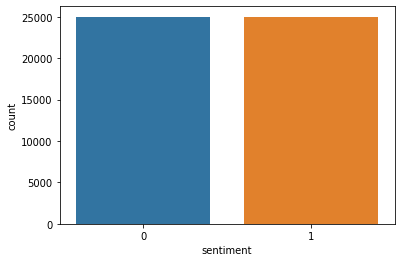

In [61]:
sns.countplot(imdb_data['sentiment'])

In [8]:
train_data, valid_data = train_test_split(imdb_data, test_size = 0.3)

In [9]:
print(f'Shape of the Training data is :{train_data.shape}')
print(f'Shape of the Validation data is :{valid_data.shape}')

Shape of the Training data is :(35000, 2)
Shape of the Validation data is :(15000, 2)


- Now let us define some fileds where preprocessing of the text happens.
- **data.Field**:torchtext.data.Field is a base datatype of PyTorch Text that helps with text preprocessing: tokenization, lowercasting, padding, umericalizaion and Building vocabulary.
 - **tokenize**: specifies the way of tokenizing the sentence i.e. converting sentence to words.
 - **batch_first**: The first dimension of input and output is always batch size
- **data.LabelField**: LabelField object is a special case of Field object which is used only for the classification tasks. Its only use is to set the unk_token and sequential to None by default.

In [10]:
text_field = data.Field(tokenize='spacy',include_lengths=True, unk_token='<unk>')

label_field = data.LabelField(dtype = torch.float)
# or use : LABEL = data.Field(sequential=False, use_vocab=False)

- Next we create a **DataFrameDataset** class which will allow us to load the data and the target-labels as a **DataSet** using a DataFrame as a source of data. We will create a vocabulary using the training dataset and then pass the training and validation datasets to the iterator later.

In [26]:
# source : https://gist.github.com/lextoumbourou/8f90313cbc3598ffbabeeaa1741a11c8
# to use DataFrame as a Data source
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.sentiment if not is_test else None
            text = row.review
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.review)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

- Now we have to make a list of tuples in which the first element would indicate the name of the column and then the next element would be a function instance of Field or LabelField.
- Let us firstly make it and see how it looks like...

In [27]:
# For text we have text_field object that we declared previously and same goes for the target field.
column_fields = [('review',text_field),('sentiment', label_field)]

- **NOTE:** The serial of the fields in above column field should be the same as it is in the dataset or else you may find some error.

- Let us split the data into Training and Test splits using the Dataset Class that we have written in the above cell. Let us try to unpack them and divide the dataset into Training and test Splits.

In [28]:
train_ds, val_ds = DataFrameDataset.splits(column_fields, train_df=train_data, val_df=valid_data)

- Let us have a look at how our preprocessing is being done.

In [30]:
# Printing our processed text
print(vars(train_ds[15]))

# Checking the type of our text
print(type(train_ds[15]))

{'review': ['This', 'belongs', 'in', 'their', 'top', 'tier', ',', 'although', 'there', 'were', 'others', ',', 'such', 'as', 'Micro', '-', 'Phonies', 'and', 'Punch', 'Drunks', ',', 'that', 'were', 'more', 'deserving', 'of', 'Oscar', 'nominations', 'than', 'this', 'one', '.', 'But', 'if', 'nothing', 'else', ',', 'the', 'recurring', 'loudspeaker', 'announcement', ',', '"', 'Dr.', 'Howard', ',', 'Dr.', 'Fine', ',', 'Dr.', 'Howard', ',', '"', 'followed', 'by', 'Curly', "'s", '"', 'Woo', 'woo', 'woo', 'woo', ',', '"', 'makes', 'this', 'a', 'classic', 'on', 'two', 'levels', '.', 'First', ',', 'it', 'symbolizes', 'all', 'that', 'the', 'Stooges', 'represent', ';', 'my', 'daughter', 'loves', 'to', 'repeat', 'the', 'announcement', 'when', 'she', 'is', 'in', 'the', 'middle', 'of', 'doing', 'something', 'silly', '.', 'Second', ',', 'the', 'absurdity', 'of', 'these', 'three', 'as', 'physicians', 'in', 'a', 'hospital', ';', 'I', 'imagine', 'the', 'terror', 'I', 'would', 'feel', 'if', 'I', 'were', 'a'

- As we are done with all the Dataloading tasks now let us set parameters for setting a sentence length and frequency of the words we have in our dataset.
## Sentence padding and setting seqeunces.


In [33]:
#initialize glove embeddings
text_field.build_vocab(train_ds,min_freq=5)# use vectors as a parameter to consider pretrained embeddings(vectors = "glove.6B.100d")  
label_field.build_vocab(train_ds)

#No. of unique words in our text corpus
print("Size of TEXT Corpus:",len(text_field.vocab))

#No. of unique tokens in label
print('\n')
print("Size of LABEL vocabulary:",len(label_field.vocab))
 

Size of TEXT Corpus: 42569


Size of LABEL vocabulary: 2


- We have succesfully made our vocabulary for our train data.
- We have around 58K unique words in our vocabulary.
- Let us have a look at the top 10 most occuring words in our corpus.

In [34]:
#Commonly used words
top_ten_words = text_field.vocab.freqs.most_common(10) # Fetches out the top 1o words using .most_common() method
for top_words in top_ten_words:# Looping through words
    print(f'Word "{top_words[0]}" repeated {top_words[1]} times in the whole corpus')

Word "the" repeated 402432 times in the whole corpus
Word "," repeated 380305 times in the whole corpus
Word "." repeated 328228 times in the whole corpus
Word "a" repeated 216831 times in the whole corpus
Word "and" repeated 216724 times in the whole corpus
Word "of" repeated 200464 times in the whole corpus
Word "to" repeated 185492 times in the whole corpus
Word "is" repeated 150515 times in the whole corpus
Word "in" repeated 122108 times in the whole corpus
Word "I" repeated 108986 times in the whole corpus


- We can see the top 10 words of our corpus.
- Now let us look at Dictionary of the word corpus that we just made right now.

In [35]:
#Word dictionary
text_field.vocab.stoi # "stoi" stands for string to Index.

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f8640c07e90>>,
            {'<unk>': 0,
             '<pad>': 1,
             'the': 2,
             ',': 3,
             '.': 4,
             'a': 5,
             'and': 6,
             'of': 7,
             'to': 8,
             'is': 9,
             'in': 10,
             'I': 11,
             'it': 12,
             'that': 13,
             '"': 14,
             "'s": 15,
             'this': 16,
             '-': 17,
             '/><br': 18,
             'was': 19,
             'as': 20,
             'with': 21,
             'movie': 22,
             'for': 23,
             'film': 24,
             'The': 25,
             'but': 26,
             'on': 27,
             "n't": 28,
             '(': 29,
             ')': 30,
             'you': 31,
             'are': 32,
             'not': 33,
             'have': 34,
             'his': 35,
             'be': 36,
             'he': 37,

- The indexes are given randomly to each unique word.
- Let us now instantiate an iterator that iterates through each and every text.

In [36]:
# Set batch size
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Setting up a Device based on GPU availability.

#Instantiate an iterator.
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## Building the Model
- Let us choose a LSTM Architecture as a model and then try to stack word embeddings layer with that one.

In [38]:
class LSTM_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        # Using Embedding Layer.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        # Using Bidirectional LSTM Layer.
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim) # Hidden dimension is multiplied by 2 because of Bidirectional.
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

- Let us define our **HyperParameters** for the current Architecture.

In [41]:
# Setting up the Hyperparameters.
num_epochs = 10 # Num of times to make propagation.
learning_rate = 0.001 # Setting up a Learning rate.

INPUT_DIM = len(text_field.vocab) # Desired or fixed size of the Vocabulary of the Text Corpus.
EMBEDDING_DIM = 200 # Number of Embedding Dimension we would want to give to a single token of a text.
HIDDEN_DIM = 256 # Number of Hidden cells or (Unoficially can be regarded to Neurons).
OUTPUT_DIM = 1 # Number of output neurons. Using 1 for binary classifier problem.
N_LAYERS = 2 # Number of Neural Network Layers.
BIDIRECTIONAL = True # If given true then applies bidirectional RNN
DROPOUT = 0.2
PAD_IDX = text_field.vocab.stoi[text_field.pad_token] # padding index sizes.

- Now let us instantiate an object for our RNN Model class.

In [42]:
# Declaring a LSTM Biderectional Model.
lstm_model = LSTM_Classifier(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

- Let us have a Look at our Model Parameters.

In [43]:
# Printing the Model architecture
print(lstm_model)

# Counting the No. of Model parameters
sum_parameters = 0
for p in lstm_model.parameters():
    sum_parameters = sum_parameters + p.numel()
    
print(f'The model has {sum_parameters} trainable parameters')

LSTM_Classifier(
  (embedding): Embedding(42569, 200, padding_idx=1)
  (rnn): LSTM(200, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
The model has 11160329 trainable parameters


- Let us look at our padded Sequences.

In [44]:
lstm_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(lstm_model.embedding.weight.data)

tensor([[-0.6946, -1.3275, -1.1976,  ...,  0.5030, -1.0236, -1.7686],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.0520, -0.7852,  0.1239,  ...,  1.0829, -1.2492,  0.7911],
        ...,
        [-0.2190, -0.6227,  0.7418,  ..., -0.2721, -0.8060,  1.4420],
        [-1.4085,  1.9814,  0.3051,  ..., -1.9525, -0.3150, -0.1605],
        [ 0.1957, -1.1390,  0.8791,  ..., -0.2060, -2.0420,  0.4384]])


- Let us set some more of the Important Model Parameters.

In [46]:
# Setting Model to current Device.
lstm_model.to(device) #CPU to GPU
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Defining a Metric that calculates the Accuracy.
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

# Defining Training and Evaluating Methods
- We would be defining some functions that can train our model and also evaluate the performane.

In [50]:
# A Function that can Train our model at each and every epoch. 

def train(model, iterator):
    
    epoch_loss = 0 # Instantiating the loss as zero.
    epoch_accuracy = 0 # Instantiating the accuaracy accuracy.
    
    model.train() # This actually lets the model to work with dropout.
    
    for batch in iterator: # Iterating via For loop the Data_Iterator.
        text, text_lengths = batch.review # Unpacking text and its lengths from a single batch.
        
        optimizer.zero_grad() 
        predictions = model(text, text_lengths.cpu()).squeeze(1) # Setting lengths to CPU and Squeezing the model for a while.
        batch_loss = criterion(predictions, batch.sentiment) # Calculating the Loss.
        batch_accuracy = binary_accuracy(predictions, batch.sentiment) # Calculating the Accuracy.

        batch_loss.backward() # BackPropagate Step
        optimizer.step() # Setting Optimizer a step ahead
        
        epoch_loss += batch_loss.item()
        epoch_accuracy += batch_accuracy.item()
        

    return epoch_loss / len(iterator), epoch_accuracy / len(iterator) # Returning loss and accuracy

In [54]:
# A function that Evaluates the performance of the model at each epoch.

def evaluate(model, iterator):
    
    epoch_loss = 0 # Instantiating the loss as zero.
    epoch_accuracy = 0 # Instantiating the accuaracy accuracy.
    
    model.eval() # Unlocking all the Nodes to get rid of Dropout.
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.review
            predictions = model(text, text_lengths.cpu()).squeeze(1)
            loss = criterion(predictions, batch.sentiment)
            acc = binary_accuracy(predictions, batch.sentiment)
            epoch_loss += loss.item()
            epoch_accuracy += acc.item()
        
    return epoch_loss / len(iterator) ,epoch_accuracy / len(iterator)

# Training our Model

In [55]:
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(lstm_model, train_iterator)
    valid_loss, valid_acc = evaluate(lstm_model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.534 | Train Acc: 71.16%
	Valid Loss: 0.453 | Valid Acc: 78.55%
	Train Loss: 0.368 | Train Acc: 80.78%
	Valid Loss: 0.290 | Valid Acc: 87.72%
	Train Loss: 0.307 | Train Acc: 83.74%
	Valid Loss: 0.272 | Valid Acc: 89.05%
	Train Loss: 0.254 | Train Acc: 85.88%
	Valid Loss: 0.264 | Valid Acc: 89.45%
	Train Loss: 0.222 | Train Acc: 87.20%
	Valid Loss: 0.285 | Valid Acc: 89.36%
	Train Loss: 0.193 | Train Acc: 88.18%
	Valid Loss: 0.306 | Valid Acc: 90.14%
	Train Loss: 0.175 | Train Acc: 88.73%
	Valid Loss: 0.320 | Valid Acc: 89.84%
	Train Loss: 0.165 | Train Acc: 89.27%
	Valid Loss: 0.328 | Valid Acc: 89.10%
	Train Loss: 0.161 | Train Acc: 89.38%
	Valid Loss: 0.415 | Valid Acc: 89.67%
	Train Loss: 0.151 | Train Acc: 89.55%
	Valid Loss: 0.446 | Valid Acc: 89.34%
time:731.787


# Visualizing our Results.
- Let us normalize all our Scores and try to visualize the results and try to analyze and choose best epoch for the LSTM Model.

<function matplotlib.pyplot.show>

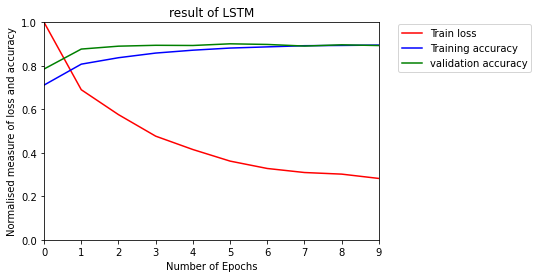

In [59]:
plt.xlabel("Number of Epochs")
plt.ylabel("Normalised measure of loss and accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r',label="Train loss")
plt.plot(x_len, acc, 'b', label="Training accuracy")
plt.plot(x_len, val_acc, 'g', label="validation accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

- Looks like When Model runs for approximately **7 Epochs** the Bias Variance parameter is being balanced.
# THANK YOU !